In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 
EPOCHS=50

In [3]:
#api to Generate a tf.data.Dataset from image files in a directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
    
    
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 2 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1]


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


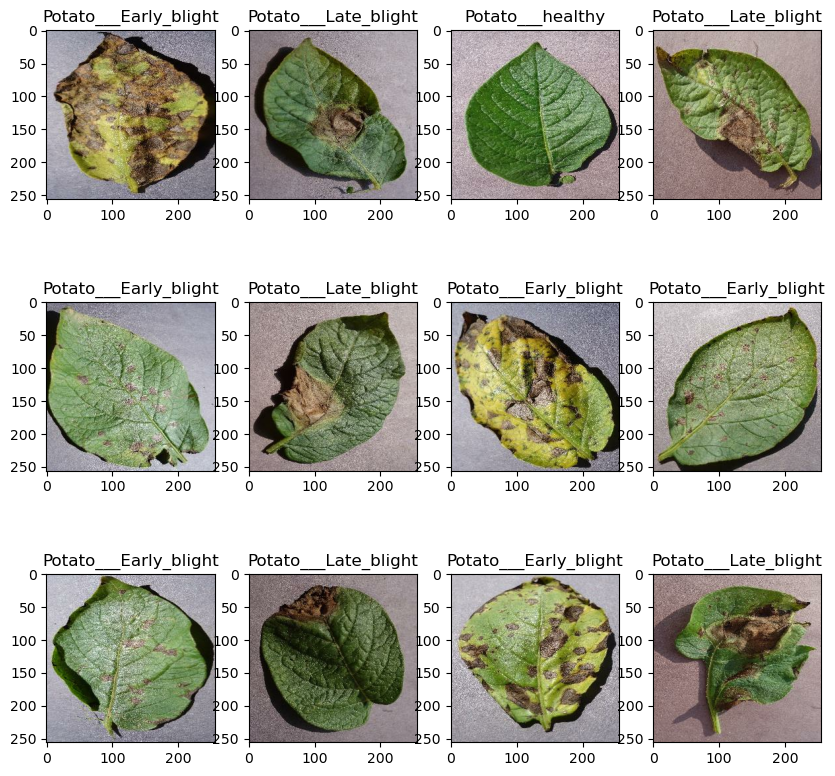

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [9]:
len(dataset) #actual length is 68*32 beacuse each element is 32 batch

68

In [10]:
#Split dataset into
# 80% ==> training
# 20% ==> validation, 10% test

In [11]:
train_size=0.8
len(dataset)*train_size


54.400000000000006

In [12]:
train_ds=dataset.take(54) #like slicing operator arr[:54]
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)  #like slicing operator arr[54:]
len(test_ds)

14

In [14]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [17]:
#Combining the above steps into one function to split the dataset

def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds


In [18]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds),len(val_ds), len(test_ds)

(54, 6, 8)

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [22]:
data_augmentation= tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    
])


In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [24]:
n_classes = 3

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),  # Exclude batch size here
    resize_and_rescale,  # Assuming this resizes and rescales your data
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

C:\Users\tharu\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Layer (type)             ┃ Output Shape      ┃   Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ sequential (Sequential)  │ (None, 256, 256,  │         0 │
│                          │ 3)                │           │
├──────────────────────────┼───────────────────┼───────────┤
│ conv2d (Conv2D)          │ (None, 254, 254,  │       896 │
│                          │ 32)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ max_pooling2d            │ (None, 127, 127,  │         0 │
│ (MaxPooling2D)           │ 32)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ conv2d_1 (Conv2D)        │ (None, 125, 125,  │    18,496 │
│                          │ 64)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ max_pooling2d_1          │ (None, 62, 62,    │         0 │
│ (MaxPooling2D)           │ 64)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ conv2d_2 (Conv2D)        │ (None, 60, 60,    │    36,928 │
│                          │ 64)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ max_pooling2d_2          │ (None, 30, 30,    │         0 │
│ (MaxPooling2D)           │ 64)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ conv2d_3 (Conv2D)        │ (None, 28, 28,    │    36,928 │
│                          │ 64)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ max_pooling2d_3          │ (None, 14, 14,    │         0 │
│ (MaxPooling2D)           │ 64)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ conv2d_4 (Conv2D)        │ (None, 12, 12,    │    36,928 │
│                          │ 64)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ max_pooling2d_4          │ (None, 6, 6, 64)  │         0 │
│ (MaxPooling2D)           │                   │           │
├──────────────────────────┼───────────────────┼───────────┤
│ flatten (Flatten)        │ (None, 2304)      │         0 │
├──────────────────────────┼───────────────────┼───────────┤
│ dense (Dense)            │ (None, 64)        │   147,520 │
├──────────────────────────┼───────────────────┼───────────┤
│ dense_1 (Dense)          │ (None, 3)         │       195 │
└──────────────────────────┴───────────────────┴───────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs=30,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.4769 - loss: 0.9337 - val_accuracy: 0.5000 - val_loss: 0.8137
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 654ms/step - accuracy: 0.7041 - loss: 0.6646 - val_accuracy: 0.8177 - val_loss: 0.3754
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 606ms/step - accuracy: 0.8663 - loss: 0.3288 - val_accuracy: 0.8542 - val_loss: 0.3266
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 761ms/step - accuracy: 0.9188 - loss: 0.2252 - val_accuracy: 0.9167 - val_loss: 0.2064
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 609ms/step - accuracy: 0.9218 - loss: 0.2271 - val_accuracy: 0.9375 - val_loss: 0.1549
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 703ms/step - accuracy: 0.9252 - loss: 0.1978 - val_accuracy: 0.8802 - val_loss: 0.2740
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 781ms/step - accuracy: 0.9336 - loss: 0.1768 - val_accuracy: 0.9062 - val_loss: 0.2148
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9488 - loss: 0.1354 - val_accuracy: 

In [28]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.9781 - loss: 0.0545


In [29]:
scores

[0.046364106237888336, 0.98046875]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [32]:
history.history['accuracy']

[0.5266203880310059,
 0.7754629850387573,
 0.8715277910232544,
 0.9149305820465088,
 0.9166666865348816,
 0.9265046119689941,
 0.9484953880310059,
 0.9380787014961243,
 0.9548611044883728,
 0.9502314925193787,
 0.9461805820465088,
 0.9583333134651184,
 0.9704861044883728,
 0.9635416865348816,
 0.9513888955116272,
 0.9525462985038757,
 0.9519675970077515,
 0.9554398059844971,
 0.9589120149612427,
 0.953125,
 0.9693287014961243,
 0.96875,
 0.9733796119689941,
 0.9704861044883728,
 0.9728009104728699,
 0.9774305820465088,
 0.9722222089767456,
 0.9658564925193787,
 0.96875,
 0.9716435074806213]

In [33]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [34]:
acc= history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (50,) and (30,)

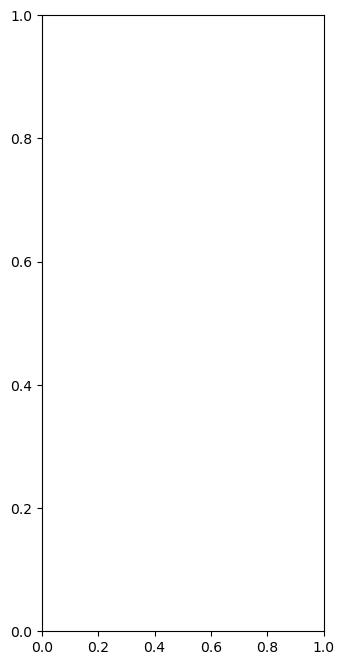

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy' )

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print(np.argmax(batch_prediction[0])) #index of highest prediction
    print("predicted label:", class_names[np.argmax(batch_prediction[0])]) #class name of highest prediction

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
        
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual : {actual_class}, \n Predicted : {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")

In [38]:
import os
import tensorflow as tf

# Define the models directory path
models_dir = "../models"

# Create the models directory if it does not exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Determine the next model version number
# List directories and add a dummy '0' to handle the case when the directory is empty
model_versions = [int(i) for i in os.listdir(models_dir) if i.isdigit()] + [0]
model_version = max(model_versions) + 1

# Define the model saving path
model_save_path = os.path.join(models_dir, f"{model_version}.h5")

# Example model creation (replace this with your actual model creation code)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Export the model to H5 format
model.save(model_save_path)

print(f"Model saved to {model_save_path}")


C:\Users\tharu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model saved to ../models\1.h5


In [40]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

# Define the models directory path
models_dir = "../models"

# Create the models directory if it does not exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Determine the next model version number
model_versions = [int(i) for i in os.listdir(models_dir) if i.isdigit()] + [0]
model_version = max(model_versions) + 1

# Define the model saving path in native Keras format
model_save_path = os.path.join(models_dir, f"{model_version}.keras")

# Define the model
model = tf.keras.Sequential([
    Input(shape=(784,)),  # Define input shape with Input layer
    Dense(10, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model (necessary before saving)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Export the model to Keras format
model.save(model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to ../models\1.keras


In [9]:
import tensorflow as tf

# Load the converted model in HDF5 format
MODEL = tf.keras.models.load_model('../saved_models/1.h5')


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../saved_models/1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)